In [8]:
pneumonia_path = 'chest_xray/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'

normal_path = 'chest_xray/chest_xray/test/NORMAL/IM-0005-0001.jpeg'

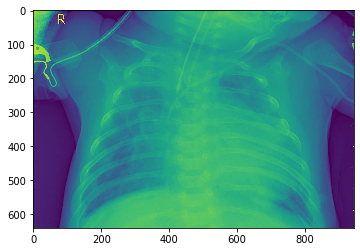

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

img = mpimg.imread(pneumonia_path)
#imgplot = plt.imshow(img, cmap = 'gray')
imgplot = plt.imshow(img)

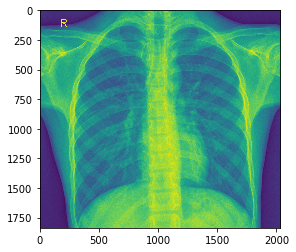

In [10]:
img = mpimg.imread(normal_path)
imgplot = plt.imshow(img)

In [12]:
#import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (64, 64)
datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [14]:
train_generator = datagen.flow_from_directory(
        'chest_xray/chest_xray/train',
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=32,
        class_mode='binary')

x_val, y_val = next(datagen.flow_from_directory(
        'chest_xray/chest_xray/val',
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=32,
        class_mode='binary')) # one big batch

x_test, y_test = next(datagen.flow_from_directory(
        'chest_xray/chest_xray/test',
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=180,
        class_mode='binary')) # one big batch

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=x_test.shape[1:]))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
__________________________________________

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('pneumonia_cnn')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]

In [17]:
#First Round 
model.fit_generator(train_generator, 
                    steps_per_epoch=100, 
                    validation_data = (x_val, y_val), 
                    epochs = 1, 
                    callbacks = callbacks_list)

   
# Save the entire model as a SavedModel
model.save('pneumonia_cnn') 

 99/100 [============================>.] - ETA: 0s - loss: 0.3527 - binary_accuracy: 0.8428 - mean_absolute_error: 0.2316
Epoch 00001: val_loss improved from inf to 1.25592, saving model to pneumonia_cnn_weights.best.hdf5
100/100 [==============================] - 25s 253ms/step - loss: 0.3527 - binary_accuracy: 0.8422 - mean_absolute_error: 0.2313 - val_loss: 1.2559 - val_binary_accuracy: 0.5625 - val_mean_absolute_error: 0.4525


In [18]:
scores = model.evaluate(x_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("val_loss:", scores[0])
print("val_mean_absolute_error:", scores[2])


180/180 [==============================] - 0s 314us/sample - loss: 0.6058 - binary_accuracy: 0.7333 - mean_absolute_error: 0.2739
binary_accuracy: 73.33%
val_loss: 0.6058288680182563
val_mean_absolute_error: 0.27389753


In [19]:
# Continued Training
model.fit_generator(train_generator, 
                    steps_per_epoch=100, 
                    validation_data = (x_val, y_val), 
                    epochs = 11, 
                    callbacks = callbacks_list)

Epoch 1/11
 99/100 [============================>.] - ETA: 0s - loss: 0.2272 - binary_accuracy: 0.9066 - mean_absolute_error: 0.1400
Epoch 00001: val_loss improved from 1.25592 to 0.65496, saving model to pneumonia_cnn_weights.best.hdf5
100/100 [==============================] - 25s 250ms/step - loss: 0.2279 - binary_accuracy: 0.9053 - mean_absolute_error: 0.1405 - val_loss: 0.6550 - val_binary_accuracy: 0.6875 - val_mean_absolute_error: 0.3890
Epoch 2/11
 99/100 [============================>.] - ETA: 0s - loss: 0.1933 - binary_accuracy: 0.9211 - mean_absolute_error: 0.1185  ETA: 10s - loss: 0.2041 - binary_accu
Epoch 00002: val_loss did not improve from 0.65496
100/100 [==============================] - 24s 243ms/step - loss: 0.1927 - binary_accuracy: 0.9212 - mean_absolute_error: 0.1182 - val_loss: 0.9060 - val_binary_accuracy: 0.6875 - val_mean_absolute_error: 0.3792
Epoch 3/11
 99/100 [============================>.] - ETA: 0s - loss: 0.1802 - binary_accuracy: 0.9328 - mean_absolu

In [20]:
model.load_weights(weight_path)
scores = model.evaluate(x_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("val_loss:", scores[0])
print("val_mean_absolute_error:", scores[2])

180/180 [==============================] - 0s 289us/sample - loss: 0.3316 - binary_accuracy: 0.8833 - mean_absolute_error: 0.1799
binary_accuracy: 88.33%
val_loss: 0.3315822104612986
val_mean_absolute_error: 0.17987402


In [21]:
pred_Y = model.predict(x_test, batch_size = 32, verbose = True)
print(pred_Y[:15])

180/180 [==============================] - 0s 380us/sample
[[0.22152719]
 [0.02945104]
 [0.9374955 ]
 [0.7778206 ]
 [0.99926543]
 [0.58494663]
 [0.9834777 ]
 [0.9893411 ]
 [0.99813676]
 [0.993845  ]
 [0.18213612]
 [0.29231203]
 [0.99583375]
 [0.9749321 ]
 [0.99934995]]


In [22]:
print(y_test[:15])

[1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.]


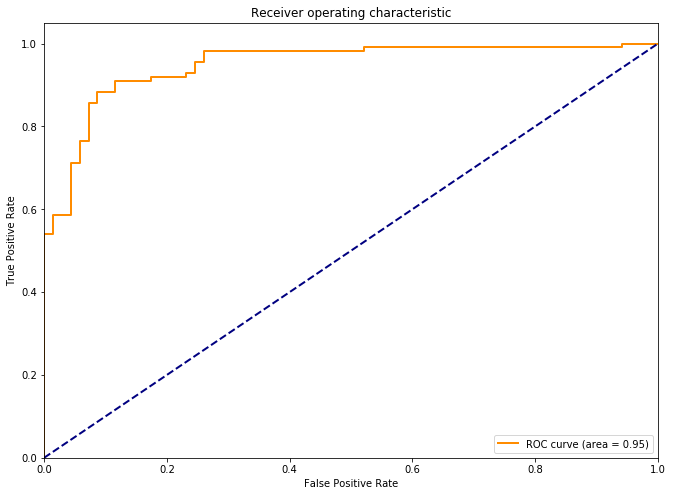

In [23]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class

num_classes = 0

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, pred_Y)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(11,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('roc2.png')